# Bolometry inversion example


## Defining the lines-of-sight

The `tokamesh` library has a tool for generating the origins and directions of radial fans of lines-of-sight:

In [71]:
from tokamesh.diagnostics import radial_fan

# generate both an upper and lower fan of lines on the outboard side of MAST-U
upper_fan_origins, upper_fan_directions = radial_fan(
    n_lines=8,
    poloidal_position=(1.75, 0.85),
    phi=0.3,
    angle_range=(180, 235)
)

lower_fan_origins, lower_fan_directions = radial_fan(
    n_lines=8,
    poloidal_position=(1.75, -0.85),
    phi=0.3,
    angle_range=(125, 180)
)

# concatenate the upper and lower lines into a single group
from numpy import concatenate
fan_origins = concatenate([upper_fan_origins, lower_fan_origins], axis=0)
fan_directions = concatenate([upper_fan_directions, lower_fan_directions], axis=0)

Now we have the origins and directions, we need to calculate the end-points of the lines, where they intersect with the machine wall:

In [72]:
from numpy import ndarray, sin, cos, stack, atan2, sqrt, zeros

def radial_surface_intersection(
    origins: ndarray, directions: ndarray, radius: float
) -> ndarray:
    # radial unit vector
    phi = atan2(origins[:, 1], origins[:, 0])
    R_unit = -stack([cos(phi), sin(phi), zeros(phi.size)], axis=1).squeeze()

    radial_projection = (directions * R_unit).sum(axis=1)
    R_origin = sqrt(origins[:, 1] ** 2 + origins[:, 0] ** 2)
    intersection_distances = (R_origin - radius) / radial_projection

    endpoints = origins + directions * intersection_distances[:, None]
    return endpoints


fan_endpoints = radial_surface_intersection(
    origins=fan_origins,
    directions=fan_directions,
    radius=0.25
)

Use the calculated line-of-sight information to calculate the geometry matrix

In [73]:
from tokamesh.geometry import calculate_geometry_matrix
from integration_mesh import mesh_data
R, z, triangles = mesh_data

geomat = calculate_geometry_matrix(
    R=R,
    z=z,
    triangles=triangles,
    ray_ends=fan_endpoints,
    ray_origins=fan_origins,
    n_processes=1
)

 >> Calculating geometry matrix:  [ completed in 0:00:00 ]                 


We can also now visualise the lines-of-sight and the triangular mesh which together define the geometry matrix:

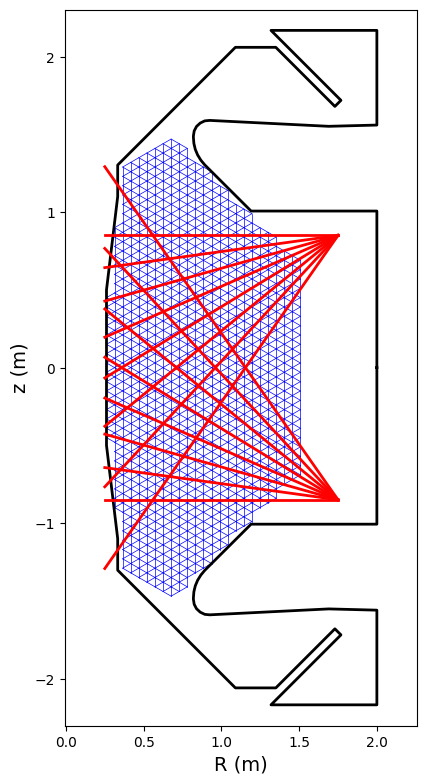

In [74]:
from tokamesh import TriangularMesh
from tokamesh.tokamaks import mastu_boundary
from numpy import array

mesh = TriangularMesh(R=R, z=z, triangles=triangles)

fan_R = array([
    sqrt(fan_origins[:, 0] ** 2 + fan_origins[:, 1] ** 2),
    sqrt(fan_endpoints[:, 0] ** 2 + fan_endpoints[:, 1] ** 2),
])

import matplotlib.pyplot as plt
fan_z = array([fan_origins[:, 2], fan_endpoints[:, 2]])
fig = plt.figure(figsize=(4.5, 8))
plt.axis("equal")
mesh.draw(ax=plt, color="blue", lw=0.5)
plt.plot(*mastu_boundary(), lw=2, color="black")
plt.plot(fan_R, fan_z, color="red", lw=2)
plt.xlabel("R (m)", fontsize=14)
plt.ylabel("z (m)", fontsize=14)
plt.ylim([-2, 2])
plt.tight_layout()
plt.show()

## Defining the forward-model

First we need to define a `FieldRequest`, which specifies the field information required by our forward-model to evaluate its predictions:

In [75]:
from midas.parameters import FieldRequest

vertex_emission_request = FieldRequest(
    name="emissivity",
    coordinates={"R":R, "z":z}
)

`midas` has a template for a purely linear forward-model which we can import and use:

In [76]:
from midas.models import LinearDiagnosticModel

bolo_model = LinearDiagnosticModel(
    field=vertex_emission_request,
    model_matrix=geomat.build_sparse_array()
)

## Defining a field model

In [77]:
from psi_model import ParametrisedPsi

psi_model = ParametrisedPsi(
    r_min=0.5,
    axis=(0.85, 0.02),
    elongation=1.85,
    triangularity=0.6,
)

from numpy import linspace
from psi_field import PsiTransform, PiecewiseFluxProfile
psi_transform = PsiTransform(
    spline=psi_model.spline
)
psi_coords = psi_transform(coords={"R": R, "z": z})
psi_vertex = psi_coords["psi"]

linear_basis_axis = linspace(0.0, 1.0, 11)
emissivity_field_model = PiecewiseFluxProfile(
    psi_transform=psi_transform,
    field_name="emissivity",
    axis_name="psi",
    axis=linear_basis_axis
)

## Building an inversion test-case

In [78]:
from numpy import exp, zeros, arange
from numpy.random import default_rng

emission_test_axis = linspace(0, 1.05, 256)

def emission_test_function(psi):
    return 1 / (1 + exp(10*(psi - 0.65)))**2

emission_test_values = emission_test_function(psi=emission_test_axis)
emissivity_vertex = emission_test_function(psi=psi_vertex)
bolo_predictions = bolo_model.predictions(emissivity=emissivity_vertex)

rng = default_rng(28)
bolo_sigma = zeros(bolo_predictions.size) + bolo_predictions*0.06 + bolo_predictions.max()*0.01
noise = rng.normal(scale=bolo_sigma, size=bolo_predictions.size)
bolo_synthetic_data = bolo_predictions + noise

We can now plot the underlying emissivity profile and the synthetic test-case data:

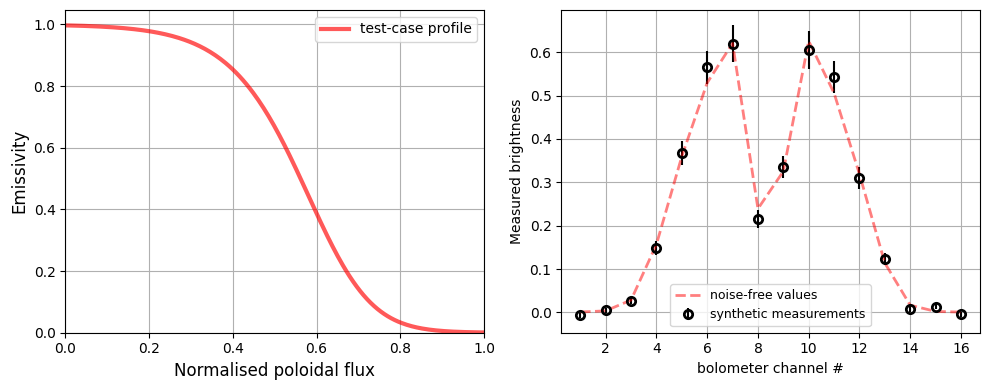

In [79]:
channels = arange(bolo_predictions.size) + 1
fig = plt.figure(figsize=(10, 4))

ax2 = fig.add_subplot(1, 2, 1)
ax2.plot(emission_test_axis, emission_test_values,  lw=3, color="red", label="test-case profile", alpha=0.65)
ax2.set_xlabel("Normalised poloidal flux", fontsize=12)
ax2.set_ylabel("Emissivity", fontsize=12)
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, None])
ax2.grid()
ax2.legend()

ax1 = fig.add_subplot(1, 2, 2)
ax1.errorbar(channels, bolo_synthetic_data, yerr=bolo_sigma, marker="o", ls="none", color="black", label="synthetic measurements", markerfacecolor="none", markeredgewidth=2, markersize=6)
ax1.plot(channels, bolo_predictions, "--",c="red", alpha=0.5, lw=2, label="noise-free values")
ax1.grid()
ax1.set_ylabel("Measured brightness")
ax1.set_xlabel("bolometer channel #")
ax1.legend(fontsize=9)

plt.tight_layout()
plt.savefig("bolo_test_case.png", dpi=300)
plt.show()

## Building the diagnostic likelihood

In [80]:
from midas.likelihoods import DiagnosticLikelihood, GaussianLikelihood

bolo_likelihood_function = GaussianLikelihood(
    y_data=bolo_synthetic_data,
    sigma=bolo_sigma
)

bolo_likelihood = DiagnosticLikelihood(
    diagnostic_model=bolo_model,
    likelihood=bolo_likelihood_function,
    name="bolometer"
)

## Building the prior distribution

In [81]:
from inference.gp import SquaredExponential, ConstantMean
from midas.priors import GaussianProcessPrior

gp_field_positions = FieldRequest(
    name="emissivity",
    coordinates={
        "R": linspace(0, 1.3, 41),
        "z": linspace(0, 0.05, 41)
    }
)

gp_prior = GaussianProcessPrior(
    covariance=SquaredExponential(),
    mean=ConstantMean(),
    field_positions=gp_field_positions,
    name="profile_smoothness_gp"
)

Next we build a prior to force the gradient of the emissivity to be small at $\psi_N = 0$:

In [82]:
from midas.parameters import ParameterVector
from midas.priors.base import BasePrior

class EmissionPeakPrior(BasePrior):
    def __init__(self):
        self.name = "emission_peak_prior"
        self.field_requests = []
        self.parameters = [ParameterVector(name="emissivity_flux_profile_basis", size=11)]
        self.sigma = 0.02
        self.weight = 1. / self.sigma**2

    def probability(self, **kwargs):
        v = kwargs["emissivity_flux_profile_basis"]
        dv = v[1] - v[0]
        return -0.5*self.weight*dv**2

    def gradients(self, **kwargs):
        v = kwargs["emissivity_flux_profile_basis"]
        dv = v[1] - v[0]
        grad = zeros(v.size)
        grad[0] = dv * self.weight
        grad[1] = -dv * self.weight
        return {"emissivity_flux_profile_basis": grad,}


axis_gradient_prior = EmissionPeakPrior()

## Building the parametrisation & posterior

In [83]:
from midas.state import PlasmaState
PlasmaState.specify_field_models(field_models=[emissivity_field_model])
PlasmaState.build_parametrisation(components=[bolo_likelihood, gp_prior, axis_gradient_prior])

## Performing the inference

In [84]:
initial_guess = PlasmaState.merge_parameters(
    parameter_values={
        "emissivity_flux_profile_basis": zeros(11) + 0.5,
        "emissivity_cov_hyperpars": [1.0, -4., -1.],
        "emissivity_mean_hyperpars": 1.0
    }
)

lower_bounds = PlasmaState.merge_parameters(
    parameter_values={
        "emissivity_flux_profile_basis": zeros(11) + 1e-4,
        "emissivity_cov_hyperpars": array([-2.0, -6.0, -4.0]),
        "emissivity_mean_hyperpars": -1.0
    }
)

upper_bounds = PlasmaState.merge_parameters(
    parameter_values={
        "emissivity_flux_profile_basis": zeros(11) + 10.,
        "emissivity_cov_hyperpars": array([2.0,-3.0, 2.0]),
        "emissivity_mean_hyperpars": 10.
    }
)

Find the model parameters which maximise the posterior probability using gradient-based optimisation:

In [85]:
from midas import posterior
from scipy.optimize import minimize

initial_log_prob = posterior.log_probability(theta=initial_guess)

opt_result = minimize(
    fun=posterior.cost,
    jac=posterior.cost_gradient,
    x0=initial_guess,
    bounds=[(l, u) for l, u in zip(lower_bounds, upper_bounds)]
)

map_params = PlasmaState.split_parameters(theta=opt_result.x)

Now we can perform uncertainty quantification by sampling from the posterior using MCMC:

  advancing chain:   [ complete - 10000 steps taken in 0:01:04 ]      


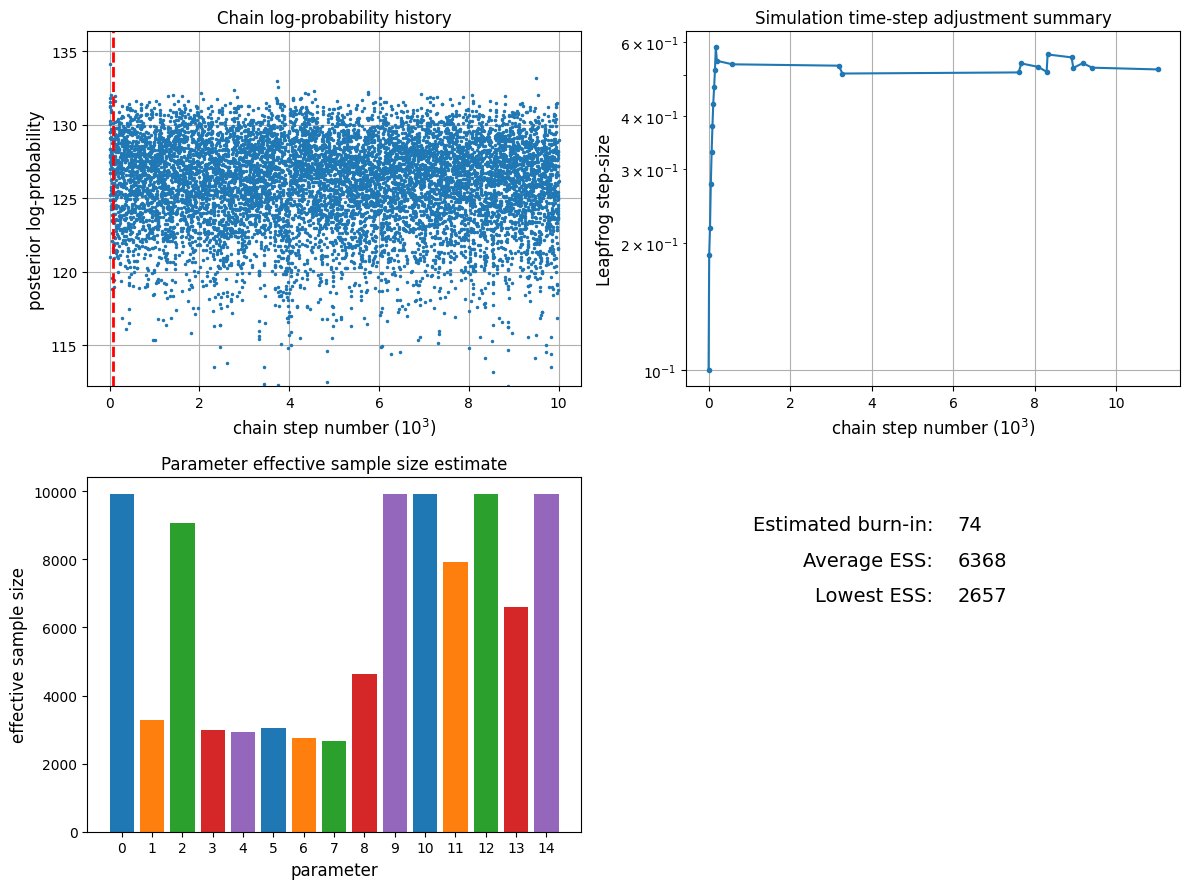

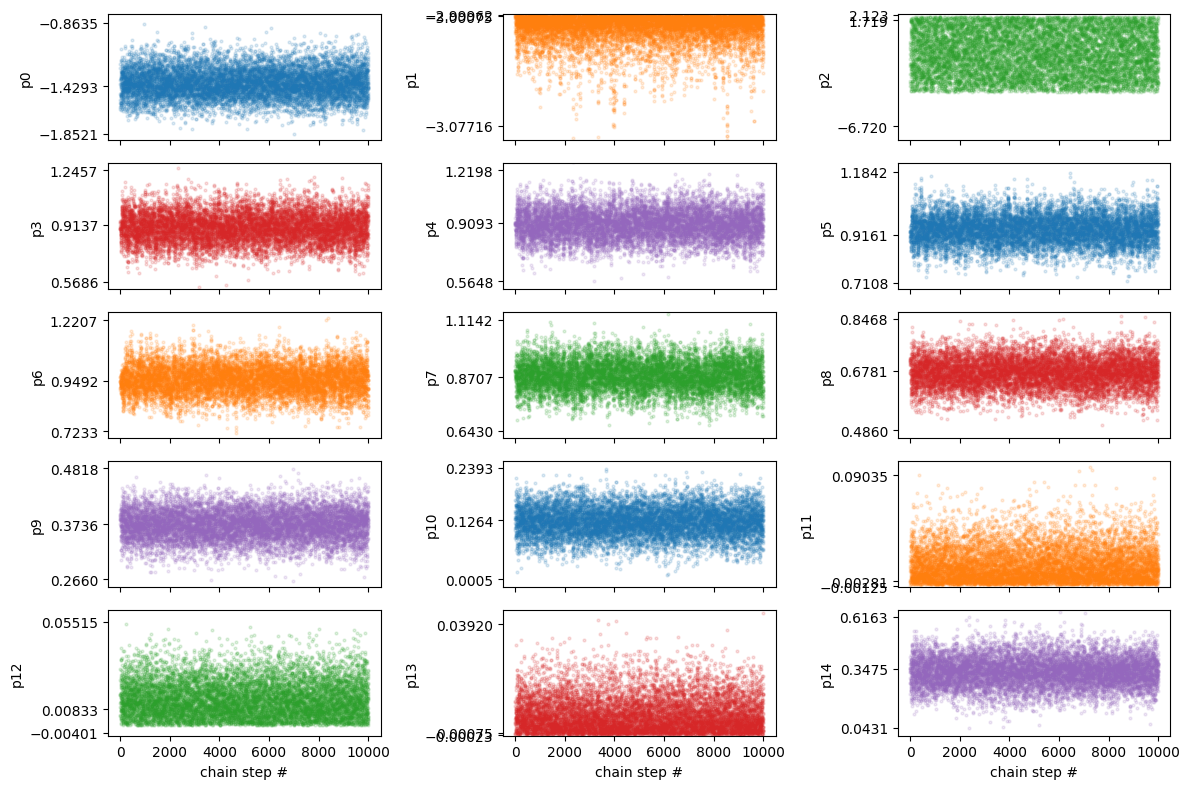

In [86]:
from inference.approx import conditional_moments

_, conditional_variances = conditional_moments(
    posterior=posterior.log_probability,
    bounds=[(l, u) for l, u in zip(lower_bounds, upper_bounds)],
    conditioning_point=opt_result.x
)

from inference.mcmc import Bounds, HamiltonianChain

hmc_bounds = Bounds(lower=lower_bounds, upper=upper_bounds)

chain = HamiltonianChain(
    posterior=posterior.log_probability,
    start=opt_result.x,
    bounds=hmc_bounds,
    grad=posterior.gradient,
    epsilon=0.1,
    inverse_mass=conditional_variances,
    display_progress=True
)
chain.steps = 20
chain.advance(10000)
chain.plot_diagnostics()
chain.trace_plot()
samples = chain.get_sample(burn=2000, thin=2)

We can now plot the inferred emissivity profile and its associated uncertainties alongside the underlying test-case profile:

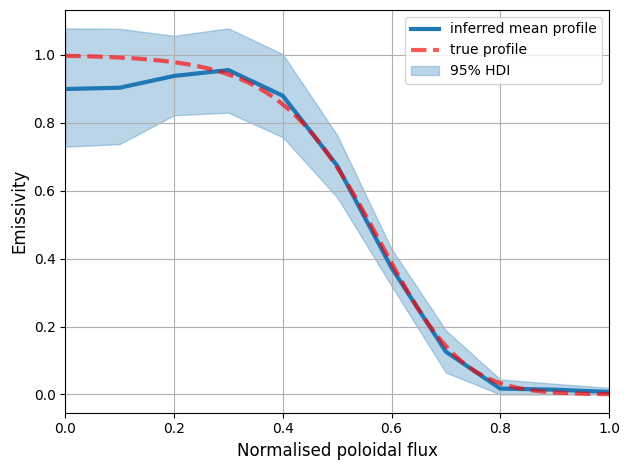

In [87]:
samples_dict = PlasmaState.split_samples(parameter_samples=samples)

from inference.pdf import sample_hdi

samples_hdi_95 = {
    name: sample_hdi(samples, fraction=0.95) for name, samples in samples_dict.items()
}

samples_mean = {name: samples.mean(axis=0) for name, samples in samples_dict.items()}


plt.plot(linear_basis_axis, samples_mean["emissivity_flux_profile_basis"], lw=3, color="C0", label="inferred mean profile")
plt.plot(emission_test_axis, emission_test_values, "--", lw=3, color="red", label="true profile", alpha=0.65)
plt.fill_between(linear_basis_axis, *samples_hdi_95["emissivity_flux_profile_basis"], alpha=0.3, color="C0", label="95% HDI")
plt.xlabel("Normalised poloidal flux", fontsize=12)
plt.ylabel("Emissivity", fontsize=12)
plt.xlim([0.0, 1.0])
plt.grid()
plt.tight_layout()
plt.legend()
plt.show()

(4001, 954)


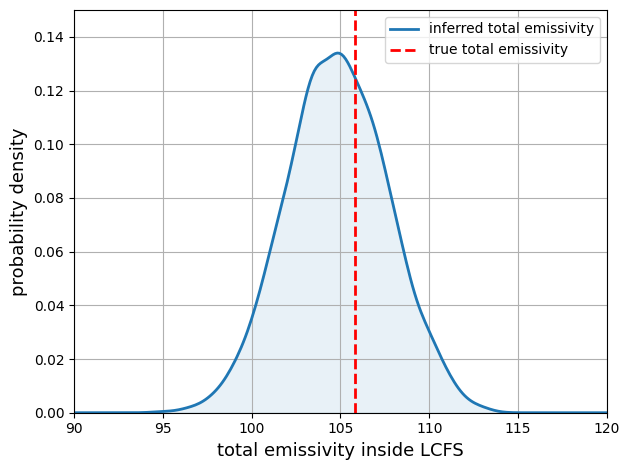

In [88]:
outside_lcfs = psi_vertex > 1.0
true_total_emission = emissivity_vertex[~outside_lcfs].sum()
vertex_emissivities = []
for s in samples_dict["emissivity_flux_profile_basis"]:
    vals = emissivity_field_model.get_values(
        parameters={"emissivity_flux_profile_basis": s},
        field=bolo_model.field_requests[0]
    )
    vals[outside_lcfs] = 0.0
    vertex_emissivities.append(vals)

vertex_emissivities = array(vertex_emissivities)
print(vertex_emissivities.shape)

total_emission = vertex_emissivities.sum(axis=1)

from inference.pdf import GaussianKDE

pdf = GaussianKDE(sample=total_emission)

total_axis = linspace(90, 120, 256)
total_pdf = pdf(total_axis)

plt.plot(total_axis, total_pdf, lw=2, c="C0", label="inferred total emissivity")
plt.fill_between(total_axis, total_pdf, color="C0", alpha=0.1)
plt.plot([true_total_emission, true_total_emission], [0.0, 1.0], c="red", ls="dashed", label="true total emissivity", lw=2)

plt.xlabel("total emissivity inside LCFS", fontsize=13)
plt.ylabel("probability density", fontsize=13)
plt.ylim([0.0, 0.15])
plt.xlim([90, 120])
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("total_emission.png", dpi=300)
plt.show()